## Case 01: Variational Autoencoder (VAE)
* Dataset: CIFAR100
* DL Framework: Tensorflow-Keras
* DL Task: Image reconstruction

`PREREQUISITE` All modules (with their suitable versions) are installed properly.
<br>`TASK` Complete the notebook cell's code marked with <b>#TODO</b> comment.
<br>`OBJECTIVE` Achieve a min. validation accuracy of <b>90%</b> within <b>10 epochs</b>.
<br>`WARNING` Do <b>NOT</b> change any codes in the <i>config.ipynb</i> file.

### Import libraries

In [392]:
from ipynb.fs.full.config import init, load_cifar_100_data, accuracy, show_reconstructions
#TODO: please import other necessary libraries here
import keras
from tensorflow import random as tf_random
from keras.layers import Conv2D
import numpy as np
from numpy import random as np_random

In [393]:
# copying from config, because fail to load from config.ipynb

from keras.datasets import cifar100
from keras.layers import Layer
from keras.metrics import binary_accuracy as ba
from tensorflow import shape as tf_shape, round as tf_round
from matplotlib import pyplot as plt
from numpy import float32


def init():
    return {"EPOCH": 10, "SEED": 42}


def load_cifar_100_data():
    (X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data()
    X_train_full, X_test = X_train_full.astype(float32) / 255, X_test.astype(float32) / 255
    X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
    y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)


def accuracy(y_true, y_pred):
    return ba(tf_round(y_true), tf_round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


def show_reconstructions(model, images, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

### Load the dataset

In [394]:
(X_train, _), (X_valid, _), (_, _) = load_cifar_100_data()
print(X_train.shape, X_valid.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3)


Try to see the first 25 images

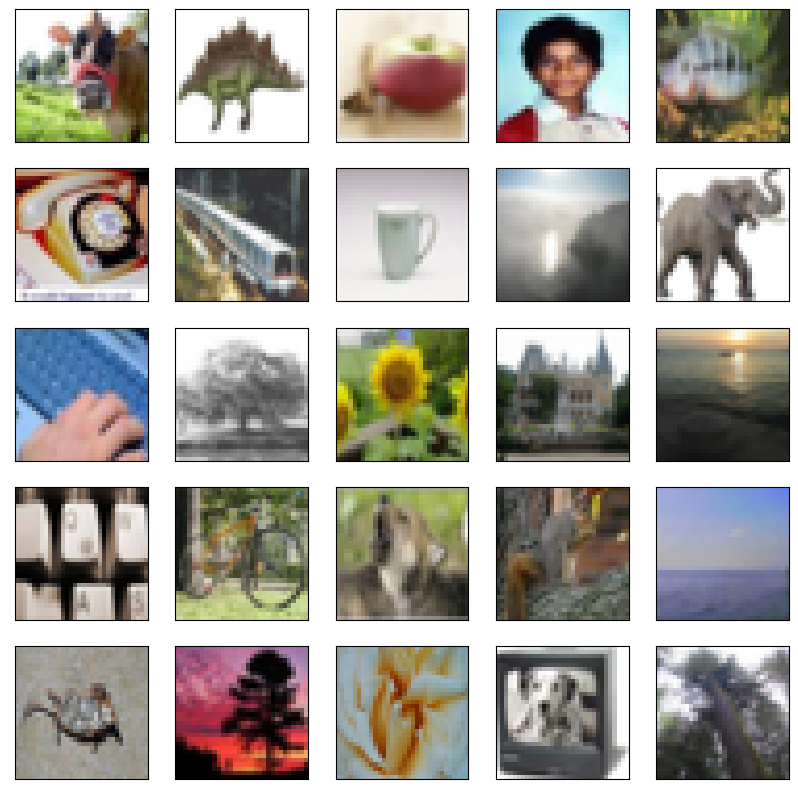

In [395]:
plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i], cmap=plt.cm.binary)

plt.show()

### Configure the hyperparameters

In [396]:
EPOCH = init()["EPOCH"] # DO NOT CHANGE THIS
SEED = init()["SEED"] # DO NOT CHANGE THIS
BATCH_SIZE = 64 #TODO: set hyperparameters (int)
CODINGS_SIZE = 128 #TODO: set parameters for the latent space representation (int)
LEARNING_RATE = 1e-4 #TODO: set hyperparameters (int)
IMG_SIZE = 32 #TODO: define the image size

In [397]:

K = keras.backend
tf_random.set_seed(SEED) # for reproduciable results
np_random.seed(SEED) # for reproduciable results

### Define the Model

In [398]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf_shape(log_var)) * K.exp(log_var / 2) + mean 

In [399]:
def encoder(i, c, *args, **kwargs):
    """
    function name:
        encoder() = to compress the image inputs (latent)
    function parameters:
        i = image size
        c = coding size
    """
    inputs = keras.layers.Input(shape=[i, i, 3])
    #TODO: define the layers stack for the encoder part. you may use MLP, LSTM, or CNN.
    # variable 'z' will be the first layer
    z = keras.layers.Conv2D(filters=8, kernel_size=3, padding="valid")(inputs)
    z = keras.layers.Conv2D(filters=16, kernel_size=3, padding="valid")(z)

    z = keras.layers.Flatten()(z)
    z = keras.layers.Dense(units=16, activation="relu")(z)

    codings_mean = keras.layers.Dense(c)(z)
    codings_log_var = keras.layers.Dense(c)(z)
    codings = Sampling()([codings_mean, codings_log_var])
    return keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]), inputs, codings_mean, codings_log_var

In [400]:
def decoder(i, c, *args, **kwargs):
    """
    function name:
        decoder = to reconstruct the image (with the same size) from the compressed version (latent)
    function parameters:
        i = image size
        c = coding size
    """
    decoder_inputs = keras.layers.Input(shape=[c, ])
    #TODO: define the layers stack for the decoder part. you may use MLP, LSTM, or CNN.
    # variable 'x' will be the first layer
    x = keras.layers.Dense(units=(28 * 28 * 16), activation="relu")(decoder_inputs)
    x = keras.layers.Reshape(target_shape=(28, 28, 16))(x)
    x = keras.layers.Conv2DTranspose(filters=8, kernel_size=3, activation="relu", padding="same")(x)
    x = keras.layers.Conv2DTranspose(filters=8, kernel_size=3, activation="relu")(x)

    outputs = keras.layers.Conv2DTranspose(
                            filters=3
                            , kernel_size=3
                            , activation="relu"
                            , padding="valid")(x)
    return keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

In [401]:
variational_encoder, inputs, codings_mean, codings_log_var = encoder(i=IMG_SIZE, c=CODINGS_SIZE)
variational_encoder.summary() # keep the trainable params below 20,000 is advised

Model: "model_112"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_101 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_140 (Conv2D)            (None, 30, 30, 8)    224         ['input_101[0][0]']              
                                                                                                  
 conv2d_141 (Conv2D)            (None, 28, 28, 16)   1168        ['conv2d_140[0][0]']             
                                                                                                  
 flatten_27 (Flatten)           (None, 12544)        0           ['conv2d_141[0][0]']             
                                                                                          

In [402]:
variational_decoder = decoder(i=IMG_SIZE, c=CODINGS_SIZE)
variational_decoder.summary() # keep the trainable params below 20,000 is advised

Model: "model_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_102 (InputLayer)      [(None, 128)]             0         
                                                                 
 dense_159 (Dense)           (None, 12544)             1618176   
                                                                 
 reshape_5 (Reshape)         (None, 28, 28, 16)        0         
                                                                 
 conv2d_transpose_86 (Conv2D  (None, 28, 28, 8)        1160      
 Transpose)                                                      
                                                                 
 conv2d_transpose_87 (Conv2D  (None, 30, 30, 8)        584       
 Transpose)                                                      
                                                                 
 conv2d_transpose_88 (Conv2D  (None, 32, 32, 3)        21

In [403]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / (np.prod(IMG_SIZE)))

### Compile the model

In [404]:
#TODO: define your loss function, optimizer, and metric
...
variational_ae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    , loss=keras.losses.MeanAbsoluteError()
    , metrics=[keras.metrics.Accuracy()]
)

### Train the model
* <b>Bechmark:</b> Validation accuracy fell at `91.48%` within 10 epochs.
* If you encounter this `WARNING:tensorflow:AutoGraph ...` in the first epoch, please ignore.

In [405]:
history = variational_ae.fit(X_train, X_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, X_valid))

Epoch 1/10
704/704 [==============================] - 70s 97ms/step - loss: 0.2822 - accuracy: 3.1447e-04 - val_loss: 0.2478 - val_accuracy: 1.6315e-04
Epoch 2/10
704/704 [==============================] - 67s 95ms/step - loss: 0.2405 - accuracy: 1.3140e-04 - val_loss: 0.2358 - val_accuracy: 1.1152e-04
Epoch 3/10
704/704 [==============================] - 71s 100ms/step - loss: 0.2321 - accuracy: 5.8131e-05 - val_loss: 0.2296 - val_accuracy: 1.7253e-05
Epoch 4/10
704/704 [==============================] - 73s 104ms/step - loss: 0.2265 - accuracy: 2.3510e-06 - val_loss: 0.2248 - val_accuracy: 1.3021e-07
Epoch 5/10
704/704 [==============================] - 70s 100ms/step - loss: 0.2234 - accuracy: 5.0637e-08 - val_loss: 0.2234 - val_accuracy: 0.0000e+00
Epoch 6/10
704/704 [==============================] - 76s 109ms/step - loss: 0.2221 - accuracy: 5.0637e-08 - val_loss: 0.2222 - val_accuracy: 0.0000e+00
Epoch 7/10
704/704 [==============================] - 73s 104ms/step - loss: 0.2216 

### Visualize training and validation results

Example output:

![VAE_acc_loss](img/vae_plot.png)

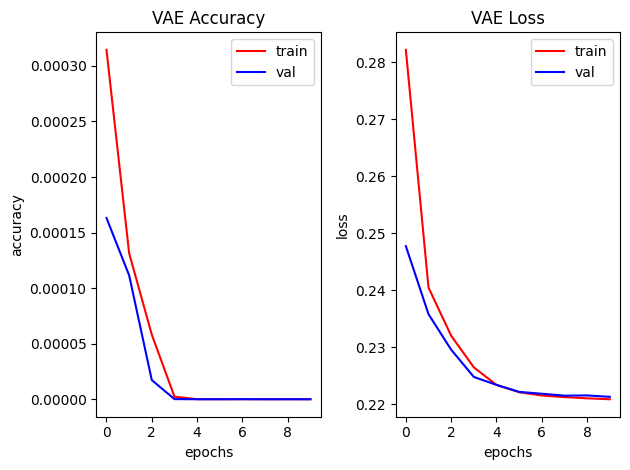

In [406]:
#TODO: plot the loss and accuracy results from both training and validation, as depicted in the image above
...
history_dict = history.history

train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

epochs = range(0, len(train_loss))

fig, ax = plt.subplots(1,2)

ax[0].plot(epochs, train_accuracy, color="r", label="train")
ax[0].plot(epochs, val_accuracy, color="b", label="val")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy")
ax[0].set_title("VAE Accuracy")
ax[0].legend()

ax[1].plot(epochs,train_loss, color="r", label="train")
ax[1].plot(epochs, val_loss, color="b", label="val")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].set_title("VAE Loss")
ax[1].legend()

plt.tight_layout()
plt.show()




### Test the model

1/1 [==============================] - 0s 230ms/step


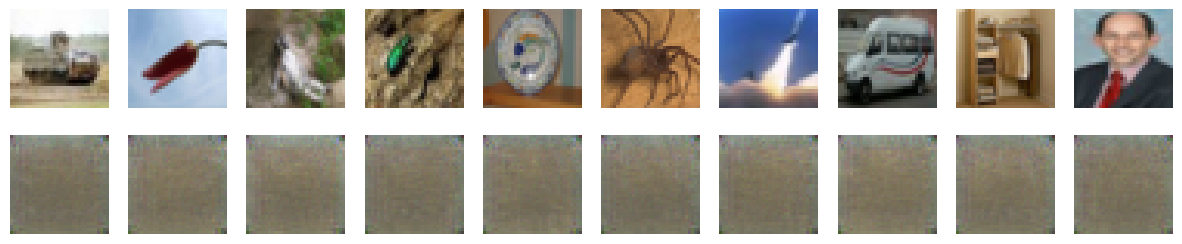

In [407]:
show_reconstructions(variational_ae, X_valid)

### Copyright 2022 PT. Agriaku Digital Indonesia
* You may NOT use this file except there is written permission from AgriAku.
* Any questions can be address to `nicholas.dominic@agriaku.com`.